In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#NLP
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import re

#modeling
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

#metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# create a non-null DF

In [ ]:
path = 'drive/My Drive/Datasets/'
file_ = 'consumer_complaints.csv'

In [ ]:
df = pd.read_csv(path+file_, low_memory=False)

In [ ]:
df[['consumer_complaint_narrative']].head()

,consumer_complaint_narrative
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [ ]:
nlp_df = df[['product', 'consumer_complaint_narrative']].copy()

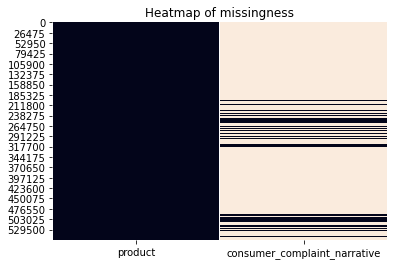

In [ ]:
#missing heat map
sns.heatmap(nlp_df.isnull(), cbar=False)
plt.title('Heatmap of missingness')
plt.show()

In [ ]:
np.sum(nlp_df.isnull())

product                              0
consumer_complaint_narrative    489151
dtype: int64

In [ ]:
#remove na from consumer_complaint_narrative 
nlp_df = nlp_df[pd.notnull(nlp_df['consumer_complaint_narrative'])]

In [ ]:
np.sum(nlp_df.isnull())

product                         0
consumer_complaint_narrative    0
dtype: int64

In [ ]:
nlp_df.shape

(66806, 2)

In [ ]:
nlp_df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


# Helper functions

In [ ]:
def clean_text(text_df, col):
  clean_df = text_df.copy()
  clean_df[col] = clean_df[col].str.lower()
  clean_df[col] = clean_df[col].str.replace('x', '')
  clean_df[col] = clean_df[col].str.replace('{', '')
  clean_df[col] = clean_df[col].str.replace('}', '')
  clean_df[col] = clean_df[col].str.replace('/', '')
  return clean_df

In [ ]:
def split_data(full_df, input_col, target_col):
  clean_df = full_df.copy()
  input_df = clean_df[[input_col]].copy()
  target_df = clean_df[[target_col]].copy()

  #split to train and test
  train_size = int(len(input_df) * .999)
  train_data = input_df[:train_size].astype('str')
  train_targets = target_df[:train_size]
  test_data = input_df[train_size:].astype('str')
  test_targets = target_df[train_size:]

  #split train into train and validation
  train_size = int(len(train_data) * .8)
  Xtrain = train_data[: train_size]
  Ytrain = train_targets[: train_size]
  Xtest = train_data[train_size : ]
  Ytest = train_targets[train_size : ]

  return (Xtrain, Ytrain), (Xtest, Ytest), (test_data, test_targets)
  

In [ ]:
def create_tf_idf(train_text, test_text):
  tfidf_vec = TfidfVectorizer(max_features=5000)

  tfidf_vec.fit(train_text['consumer_complaint_narrative'].values)

  xtrain_tfidf = tfidf_vec.transform(train_text['consumer_complaint_narrative'].values)
  xtest_tfidf = tfidf_vec.transform(test_text['consumer_complaint_narrative'].values)

  return xtrain_tfidf, xtest_tfidf, tfidf_vec

In [ ]:
def create_labels(ytrain, ytest):
  encoder = LabelEncoder()
  encoder.fit(ytrain)
  ytrain = encoder.transform(ytrain)
  ytest = encoder.transform(y_test)
  return ytrain, ytest, encoder

In [ ]:
#the function creates an empty dataframe...

def new_report():
    return pd.DataFrame(columns=['CLASSIFIER', 'ACCURACY', 'PRECISION', 
                                 'RECALL', 'F1_SCORE'])

In [ ]:
def report(classifier_name, y_true, y_hat, average):
  """
  Inputs:
      y, array of int 0/1, ground truth labels for good/fraud
      y_hat, array of int 0/1,, predicted probabilities of fraud
      
  Output: 
      report dataframe of 1 row 
  """
  accuracy = accuracy_score(y_true,y_hat)
  precision = precision_score(y_true,y_hat, average=average)
  recall = recall_score(y_true,y_hat, average=average)
  fscore = 2 * (precision * recall) / (precision + recall)

  df = new_report()
  df.loc[0] = ([classifier_name,
                f'{accuracy:.3f}',
                f'{precision:.3f}',
                f'{recall:.3f}',
                f'{fscore:.3f}',
                  ])
  return df

# create train and test set

In [ ]:
df_clean = clean_text(nlp_df, 'consumer_complaint_narrative')
train, test, val = split_data(df_clean, input_col='consumer_complaint_narrative', target_col='product')

In [ ]:
x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]

val_x = val[0]
val_y = val[1]

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape:  {x_test.shape}')
print(f'x_val shape:   {val_x.shape}')

x_train shape: (53391, 1)
x_test shape:  (13348, 1)
x_val shape:   (67, 1)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


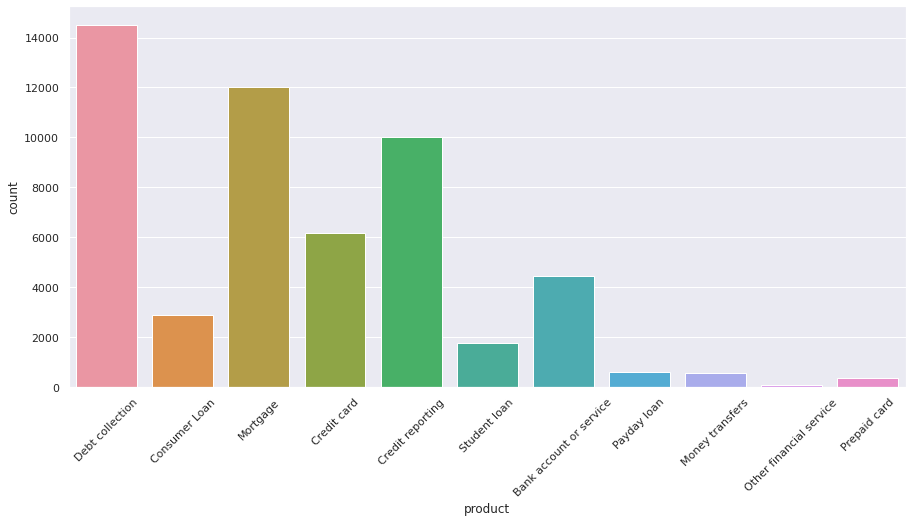

In [ ]:
sns.set(rc={'figure.figsize':(15, 7)})
chart = sns.countplot(y_train['product'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [ ]:
y_train, y_test, target_encoder = create_labels(y_train['product'].values, y_test['product'].values)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
target_encoder.classes_

array(['Bank account or service', 'Consumer Loan', 'Credit card',
       'Credit reporting', 'Debt collection', 'Money transfers',
       'Mortgage', 'Other financial service', 'Payday loan',
       'Prepaid card', 'Student loan'], dtype=object)

In [ ]:
xtrain_tfidf, xtest_tfidf, tfidf_vec = create_tf_idf(x_train, x_test)

# Building Models

## Model 1

In [ ]:
metric_report = new_report()
metric_report

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE


In [ ]:
# Create one-vs-rest logistic regression object
logistic_regression_ovr = LogisticRegression(random_state=0, multi_class="ovr", max_iter=1000)

In [ ]:
logistic_regression_ovr.fit(xtrain_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
ovr_preds = logistic_regression_ovr.predict(xtest_tfidf)

In [ ]:
metric_report = pd.concat([metric_report, report(classifier_name='Logistic_Regresion_OVR', y_true=y_test, y_hat=ovr_preds, average='weighted')])
metric_report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817


## model 2

In [ ]:
# Create multinomial logistic regression object
logistic_regression_mnl = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000)

In [ ]:
logistic_regression_mnl.fit(xtrain_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
mnl_preds = logistic_regression_mnl.predict(xtest_tfidf)

In [ ]:
metric_report = pd.concat([metric_report, report(classifier_name='Logistic_Regresion_mnl', y_true=y_test, y_hat=mnl_preds, average='weighted')])
metric_report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
0,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823


## Model 3

In [ ]:
logistic_regression_bal_cls = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000, class_weight='balanced')

In [ ]:
logistic_regression_bal_cls.fit(xtrain_tfidf, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
bal_cls_pred = logistic_regression_bal_cls.predict(xtest_tfidf)

In [ ]:
metric_report = pd.concat([metric_report, report(classifier_name='Logistic_Regresion(balanced class weight)', y_true=y_test, y_hat=bal_cls_pred, average='weighted')])
metric_report

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
0,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
0,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826


## Model 4

In [ ]:
# monitor imbalance and use newton-cg
logistic_regression_cg = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000, class_weight='balanced', solver="newton-cg")

In [ ]:
logistic_regression_cg.fit(xtrain_tfidf, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=0, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:
newton_preds = logistic_regression_cg.predict(xtest_tfidf)

In [ ]:
metric_report = pd.concat([metric_report, report(classifier_name='Logistic_Regresion(multi_newton)', y_true=y_test, y_hat=newton_preds, average='weighted')])
metric_report

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
0,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
0,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826
0,Logistic_Regresion(multi_newton),0.821,0.831,0.821,0.826


## Model 5

In [ ]:
logistic_regression_cv = LogisticRegressionCV(penalty='l2', Cs=10, multi_class="multinomial", solver="newton-cg")

In [ ]:
logistic_regression_cv.fit(xtrain_tfidf, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='newton-cg', tol=0.0001, verbose=0)

In [ ]:
lr_cv_preds = logistic_regression_cv.predict(xtest_tfidf)

In [ ]:
metric_report = pd.concat([metric_report, report(classifier_name='Logistic_RegresionCV_l2', y_true=y_test, y_hat=lr_cv_preds, average='weighted')])
metric_report

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
0,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
0,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826
0,Logistic_Regresion(multi_newton),0.821,0.831,0.821,0.826
0,Logistic_RegresionCV_l2,0.828,0.826,0.828,0.827


## Final Metric Report

In [ ]:
metric_report

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
0,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
0,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826
0,Logistic_Regresion(multi_newton),0.821,0.831,0.821,0.826
0,Logistic_RegresionCV_l2,0.828,0.826,0.828,0.827


In [ ]:
metric_report.reset_index(drop=True)

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
1,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
2,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826
3,Logistic_Regresion(multi_newton),0.821,0.831,0.821,0.826
4,Logistic_RegresionCV_l2,0.828,0.826,0.828,0.827


In [ ]:
metric_report = metric_report.reset_index(drop=True)

In [ ]:
#metric_report.to_csv(path+ 'cnsumer_complaints_metrics.csv')

,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1_SCORE
0,Logistic_Regresion_OVR,0.817,0.818,0.817,0.817
1,Logistic_Regresion_mnl,0.824,0.823,0.824,0.823
2,Logistic_Regresion(balanced class weight),0.821,0.831,0.821,0.826
3,Logistic_Regresion(multi_newton),0.821,0.831,0.821,0.826
4,Logistic_RegresionCV_l2,0.828,0.826,0.828,0.827
